In [10]:
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import torch.nn as nn
import os

%matplotlib inline

### 加载数据集

In [11]:
mnist = MNIST(root = 'data',
              train = True,
              download = True,
              transform = Compose([ToTensor(),Normalize(0.5,0.5)]))

In [12]:
img, label = mnist[5] 
print('数字是',label)
print('单张照片的维度是',img.shape)
print('数据集的一些具体参数', mnist)  #可以看出这个训练集里面包含了60000张照片

数字是 2
单张照片的维度是 torch.Size([1, 28, 28])
数据集的一些具体参数 Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


Label 2


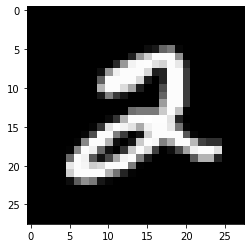

In [13]:
# 将张量转换为照片
img = img[0] #torch.squeeze(img) #转换为图片的时候需要reshape(img,(28,28)) 或者用 torch.squeeze(img) 去除张量中维度为1的那个维度
img = (img+1)/2
plt.imshow(img,cmap='gray')
print('Label',label)

### Create a dataloader to load the images in batches

first batch
torch.Size([100, 1, 28, 28])
tensor([1, 5, 0, 3, 8, 4, 7, 6, 6, 7, 8, 8, 2, 1, 1, 1, 0, 1, 9, 3, 1, 1, 2, 2,
        6, 2, 7, 7, 5, 7, 6, 1, 6, 1, 7, 8, 3, 2, 0, 2, 8, 1, 2, 9, 9, 1, 0, 3,
        7, 5, 6, 5, 4, 0, 1, 9, 2, 8, 4, 4, 6, 9, 1, 6, 3, 1, 0, 6, 6, 6, 2, 3,
        0, 6, 4, 1, 3, 2, 3, 0, 2, 8, 0, 1, 6, 0, 7, 6, 0, 5, 8, 0, 2, 1, 6, 7,
        0, 8, 5, 0])


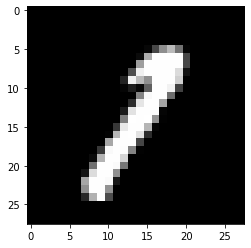

In [14]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(mnist, batch_size, shuffle = True) #shuffle的目的是每次调用都会更新排序

# 接下来可以看一下一个batch里面有什么
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

### 这一步是很重要的，需要check是否有GPU可以进行计算
对计算设备进行配置

In [18]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### 接下来分别构建判别器和生成器的神经网络

In [22]:
image_size = 784 # 28*28
hidden_size = 256
latent_size = 64

#判别器的模型，即正向传播
D = nn.Sequential(nn.Linear(image_size,hidden_size),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_size,hidden_size),
                  nn.LeakyReLU(0.2),
                  nn.Linear(hidden_size,1),
                  nn.Sigmoid())
D.to(device)

Sequential(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=256, out_features=1, bias=True)
  (5): Sigmoid()
)

In [23]:
#生成器的模型，即正向传播
G = nn.Sequential(nn.Linear(latent_size,hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size,hidden_size),
                  nn.ReLU(),
                  nn.Linear(hidden_size,image_size),
                  nn.Tanh())
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=784, bias=True)
  (5): Tanh()
)

### 先是对判别器的训练

In [29]:
#其实都是二分类，所以用二分类损失函数，即交叉熵损失函数
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [30]:
def reset_grad(): #训练开始的重置参数
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [31]:
def train_discriminator(images):
    
    # 这是BCE需要的输入，即标签的值
    real_labels = torch.ones(batch_size,1).to(device)
    fake_labels = torch.zeros(batch_size,1).to(device)
    
    # Loss for real image
    outputs = D(images)
    d_loss_real = criterion(outputs,real_labels)
    real_score = outputs
    
    # Loss for fake image
    z = torch.randn(batch_size,latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs,fake_labels)
    fake_score = outputs
    
    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    
    # 根据pytorch中backward（）函数的计算，当网络参量进行反馈时，梯度是累积计算而不是被替换，
    # 但在处理每一个batch时并不需要与其他batch的梯度混合起来累积计算，因此需要对每个batch调用一遍zero_grad（）将参数梯度置0.
    reset_grad()
    
    d_loss.backward()
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [32]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    
    fake_images = G(z)
    
    labels = torch.ones(batch_size, 1).to(device)
    
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    
    return g_loss, fake_images

### 接下来就是Train模型了

In [33]:
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

### Save a batch of real images that we can use for visual comparision while looking at the generated images.

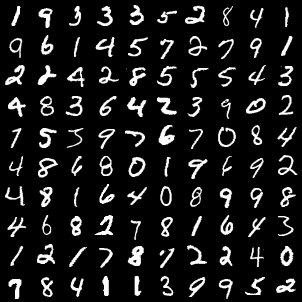

In [36]:
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image((images+1)/2 , os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))

### We'll also define a helper function to save a batch of generated images to disk at the end of every epoch. We'll use a fixed set of input vectors to the generator to see how the individual generated images evolve over time as we train the model.

Saving fake_images-0000.png


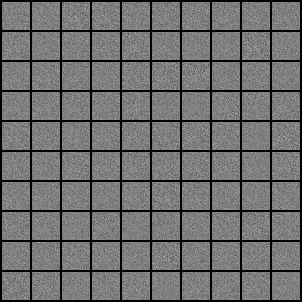

In [37]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image((fake_images+1)/2, os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [38]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0308, g_loss: 4.7179, D(x): 0.99, D(G(z)): 0.02
Epoch [0/300], Step [400/600], d_loss: 0.0905, g_loss: 6.0326, D(x): 0.98, D(G(z)): 0.06
Epoch [0/300], Step [600/600], d_loss: 0.0471, g_loss: 5.0492, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0337, g_loss: 5.6096, D(x): 0.99, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.3607, g_loss: 3.5636, D(x): 0.97, D(G(z)): 0.26
Epoch [1/300], Step [600/600], d_loss: 0.2618, g_loss: 6.2039, D(x): 0.97, D(G(z)): 0.17
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.6640, g_loss: 2.6357, D(x): 0.80, D(G(z)): 0.22
Epoch [2/300], Step [400/600], d_loss: 0.2642, g_loss: 2.8660, D(x): 0.97, D(G(z)): 0.18
Epoch [2/300], Step [600/600], d_loss: 0.1172, g_loss: 5.2414, D(x): 0.95, D(G(z)): 0.05
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.2192, g_loss: 2.8682, D(x): 0.93, D(G(z)): 0.09
Epoch [3/300], Step [400/6

Epoch [27/300], Step [600/600], d_loss: 0.3301, g_loss: 4.4931, D(x): 0.89, D(G(z)): 0.08
Saving fake_images-0028.png
Epoch [28/300], Step [200/600], d_loss: 0.2857, g_loss: 4.4052, D(x): 0.94, D(G(z)): 0.12
Epoch [28/300], Step [400/600], d_loss: 0.4204, g_loss: 4.4872, D(x): 0.94, D(G(z)): 0.20
Epoch [28/300], Step [600/600], d_loss: 0.3019, g_loss: 4.3880, D(x): 0.90, D(G(z)): 0.08
Saving fake_images-0029.png
Epoch [29/300], Step [200/600], d_loss: 0.1887, g_loss: 3.5122, D(x): 0.93, D(G(z)): 0.06
Epoch [29/300], Step [400/600], d_loss: 0.4250, g_loss: 3.9135, D(x): 0.86, D(G(z)): 0.09
Epoch [29/300], Step [600/600], d_loss: 0.3557, g_loss: 3.2361, D(x): 0.91, D(G(z)): 0.11
Saving fake_images-0030.png
Epoch [30/300], Step [200/600], d_loss: 0.2631, g_loss: 3.6295, D(x): 0.93, D(G(z)): 0.12
Epoch [30/300], Step [400/600], d_loss: 0.4459, g_loss: 2.2740, D(x): 0.85, D(G(z)): 0.09
Epoch [30/300], Step [600/600], d_loss: 0.5381, g_loss: 3.9191, D(x): 0.79, D(G(z)): 0.06
Saving fake_imag

Epoch [55/300], Step [400/600], d_loss: 0.6877, g_loss: 2.3822, D(x): 0.75, D(G(z)): 0.18
Epoch [55/300], Step [600/600], d_loss: 0.5388, g_loss: 3.1795, D(x): 0.79, D(G(z)): 0.13
Saving fake_images-0056.png
Epoch [56/300], Step [200/600], d_loss: 0.6200, g_loss: 2.6926, D(x): 0.86, D(G(z)): 0.26
Epoch [56/300], Step [400/600], d_loss: 0.7181, g_loss: 2.0134, D(x): 0.80, D(G(z)): 0.24
Epoch [56/300], Step [600/600], d_loss: 0.7576, g_loss: 2.2637, D(x): 0.76, D(G(z)): 0.18
Saving fake_images-0057.png
Epoch [57/300], Step [200/600], d_loss: 0.5001, g_loss: 2.6835, D(x): 0.82, D(G(z)): 0.17
Epoch [57/300], Step [400/600], d_loss: 0.6912, g_loss: 2.9588, D(x): 0.76, D(G(z)): 0.19
Epoch [57/300], Step [600/600], d_loss: 0.6744, g_loss: 1.7578, D(x): 0.83, D(G(z)): 0.26
Saving fake_images-0058.png
Epoch [58/300], Step [200/600], d_loss: 0.6805, g_loss: 1.8763, D(x): 0.81, D(G(z)): 0.26
Epoch [58/300], Step [400/600], d_loss: 0.5626, g_loss: 2.4443, D(x): 0.77, D(G(z)): 0.11
Epoch [58/300], 

Epoch [83/300], Step [200/600], d_loss: 0.7036, g_loss: 2.1590, D(x): 0.69, D(G(z)): 0.10
Epoch [83/300], Step [400/600], d_loss: 0.7757, g_loss: 2.0908, D(x): 0.75, D(G(z)): 0.25
Epoch [83/300], Step [600/600], d_loss: 0.8162, g_loss: 1.6785, D(x): 0.82, D(G(z)): 0.34
Saving fake_images-0084.png
Epoch [84/300], Step [200/600], d_loss: 0.5742, g_loss: 2.4211, D(x): 0.76, D(G(z)): 0.16
Epoch [84/300], Step [400/600], d_loss: 0.7502, g_loss: 2.1568, D(x): 0.83, D(G(z)): 0.31
Epoch [84/300], Step [600/600], d_loss: 0.6234, g_loss: 2.1508, D(x): 0.83, D(G(z)): 0.26
Saving fake_images-0085.png
Epoch [85/300], Step [200/600], d_loss: 0.9188, g_loss: 2.2366, D(x): 0.66, D(G(z)): 0.24
Epoch [85/300], Step [400/600], d_loss: 0.6936, g_loss: 2.0817, D(x): 0.78, D(G(z)): 0.24
Epoch [85/300], Step [600/600], d_loss: 0.6861, g_loss: 2.4962, D(x): 0.74, D(G(z)): 0.19
Saving fake_images-0086.png
Epoch [86/300], Step [200/600], d_loss: 0.6641, g_loss: 2.2181, D(x): 0.80, D(G(z)): 0.26
Epoch [86/300], 

Epoch [110/300], Step [600/600], d_loss: 0.9341, g_loss: 1.6787, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0111.png
Epoch [111/300], Step [200/600], d_loss: 0.9058, g_loss: 1.6856, D(x): 0.72, D(G(z)): 0.23
Epoch [111/300], Step [400/600], d_loss: 1.0793, g_loss: 2.5304, D(x): 0.61, D(G(z)): 0.19
Epoch [111/300], Step [600/600], d_loss: 0.7479, g_loss: 1.7211, D(x): 0.71, D(G(z)): 0.21
Saving fake_images-0112.png
Epoch [112/300], Step [200/600], d_loss: 0.9336, g_loss: 2.0858, D(x): 0.76, D(G(z)): 0.33
Epoch [112/300], Step [400/600], d_loss: 1.0618, g_loss: 1.5918, D(x): 0.69, D(G(z)): 0.33
Epoch [112/300], Step [600/600], d_loss: 0.8946, g_loss: 1.5625, D(x): 0.73, D(G(z)): 0.26
Saving fake_images-0113.png
Epoch [113/300], Step [200/600], d_loss: 0.7159, g_loss: 2.1510, D(x): 0.76, D(G(z)): 0.24
Epoch [113/300], Step [400/600], d_loss: 1.0156, g_loss: 1.6397, D(x): 0.64, D(G(z)): 0.27
Epoch [113/300], Step [600/600], d_loss: 0.9555, g_loss: 1.5487, D(x): 0.67, D(G(z)): 0.27
Saving

Epoch [138/300], Step [200/600], d_loss: 0.9185, g_loss: 1.7478, D(x): 0.69, D(G(z)): 0.29
Epoch [138/300], Step [400/600], d_loss: 0.9283, g_loss: 1.7037, D(x): 0.68, D(G(z)): 0.30
Epoch [138/300], Step [600/600], d_loss: 1.1006, g_loss: 1.5910, D(x): 0.76, D(G(z)): 0.45
Saving fake_images-0139.png
Epoch [139/300], Step [200/600], d_loss: 1.0026, g_loss: 1.6339, D(x): 0.69, D(G(z)): 0.32
Epoch [139/300], Step [400/600], d_loss: 0.9418, g_loss: 1.5316, D(x): 0.65, D(G(z)): 0.24
Epoch [139/300], Step [600/600], d_loss: 0.8372, g_loss: 1.5769, D(x): 0.78, D(G(z)): 0.33
Saving fake_images-0140.png
Epoch [140/300], Step [200/600], d_loss: 0.9998, g_loss: 1.6321, D(x): 0.61, D(G(z)): 0.26
Epoch [140/300], Step [400/600], d_loss: 0.8869, g_loss: 1.9077, D(x): 0.64, D(G(z)): 0.21
Epoch [140/300], Step [600/600], d_loss: 0.8559, g_loss: 1.4652, D(x): 0.71, D(G(z)): 0.27
Saving fake_images-0141.png
Epoch [141/300], Step [200/600], d_loss: 0.8329, g_loss: 1.8012, D(x): 0.71, D(G(z)): 0.27
Epoch 

Epoch [165/300], Step [400/600], d_loss: 0.9694, g_loss: 1.6102, D(x): 0.69, D(G(z)): 0.32
Epoch [165/300], Step [600/600], d_loss: 0.9020, g_loss: 1.6111, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0166.png
Epoch [166/300], Step [200/600], d_loss: 0.8642, g_loss: 1.5453, D(x): 0.67, D(G(z)): 0.25
Epoch [166/300], Step [400/600], d_loss: 0.9930, g_loss: 1.8585, D(x): 0.66, D(G(z)): 0.30
Epoch [166/300], Step [600/600], d_loss: 0.9352, g_loss: 1.9067, D(x): 0.62, D(G(z)): 0.24
Saving fake_images-0167.png
Epoch [167/300], Step [200/600], d_loss: 0.9650, g_loss: 1.4464, D(x): 0.79, D(G(z)): 0.42
Epoch [167/300], Step [400/600], d_loss: 1.0263, g_loss: 1.5200, D(x): 0.63, D(G(z)): 0.28
Epoch [167/300], Step [600/600], d_loss: 1.0350, g_loss: 1.3890, D(x): 0.69, D(G(z)): 0.34
Saving fake_images-0168.png
Epoch [168/300], Step [200/600], d_loss: 0.9178, g_loss: 1.7632, D(x): 0.76, D(G(z)): 0.36
Epoch [168/300], Step [400/600], d_loss: 0.9690, g_loss: 1.1668, D(x): 0.69, D(G(z)): 0.34
Epoch 

Epoch [192/300], Step [600/600], d_loss: 0.8980, g_loss: 1.9334, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0193.png
Epoch [193/300], Step [200/600], d_loss: 0.8612, g_loss: 1.8901, D(x): 0.78, D(G(z)): 0.37
Epoch [193/300], Step [400/600], d_loss: 0.9766, g_loss: 1.8521, D(x): 0.64, D(G(z)): 0.29
Epoch [193/300], Step [600/600], d_loss: 1.0414, g_loss: 1.5672, D(x): 0.62, D(G(z)): 0.30
Saving fake_images-0194.png
Epoch [194/300], Step [200/600], d_loss: 0.9325, g_loss: 1.3505, D(x): 0.72, D(G(z)): 0.35
Epoch [194/300], Step [400/600], d_loss: 0.9791, g_loss: 1.3765, D(x): 0.67, D(G(z)): 0.33
Epoch [194/300], Step [600/600], d_loss: 1.0460, g_loss: 1.2057, D(x): 0.66, D(G(z)): 0.34
Saving fake_images-0195.png
Epoch [195/300], Step [200/600], d_loss: 0.9316, g_loss: 1.4337, D(x): 0.67, D(G(z)): 0.28
Epoch [195/300], Step [400/600], d_loss: 0.9611, g_loss: 1.3799, D(x): 0.66, D(G(z)): 0.30
Epoch [195/300], Step [600/600], d_loss: 0.8679, g_loss: 1.2632, D(x): 0.69, D(G(z)): 0.30
Saving

Epoch [220/300], Step [200/600], d_loss: 1.0785, g_loss: 1.4363, D(x): 0.69, D(G(z)): 0.37
Epoch [220/300], Step [400/600], d_loss: 0.7621, g_loss: 1.8347, D(x): 0.72, D(G(z)): 0.25
Epoch [220/300], Step [600/600], d_loss: 0.7935, g_loss: 1.5521, D(x): 0.69, D(G(z)): 0.24
Saving fake_images-0221.png
Epoch [221/300], Step [200/600], d_loss: 1.0396, g_loss: 1.8956, D(x): 0.71, D(G(z)): 0.39
Epoch [221/300], Step [400/600], d_loss: 0.9411, g_loss: 1.4829, D(x): 0.64, D(G(z)): 0.26
Epoch [221/300], Step [600/600], d_loss: 0.8407, g_loss: 1.4003, D(x): 0.73, D(G(z)): 0.33
Saving fake_images-0222.png
Epoch [222/300], Step [200/600], d_loss: 0.9296, g_loss: 1.2572, D(x): 0.72, D(G(z)): 0.34
Epoch [222/300], Step [400/600], d_loss: 0.8056, g_loss: 1.5731, D(x): 0.67, D(G(z)): 0.24
Epoch [222/300], Step [600/600], d_loss: 0.8515, g_loss: 1.4735, D(x): 0.79, D(G(z)): 0.36
Saving fake_images-0223.png
Epoch [223/300], Step [200/600], d_loss: 0.8531, g_loss: 1.0793, D(x): 0.73, D(G(z)): 0.29
Epoch 

Epoch [247/300], Step [400/600], d_loss: 0.9217, g_loss: 1.3022, D(x): 0.66, D(G(z)): 0.27
Epoch [247/300], Step [600/600], d_loss: 0.9470, g_loss: 1.5087, D(x): 0.74, D(G(z)): 0.38
Saving fake_images-0248.png
Epoch [248/300], Step [200/600], d_loss: 0.8000, g_loss: 1.4921, D(x): 0.70, D(G(z)): 0.25
Epoch [248/300], Step [400/600], d_loss: 0.9158, g_loss: 1.4071, D(x): 0.69, D(G(z)): 0.31
Epoch [248/300], Step [600/600], d_loss: 1.0079, g_loss: 1.2097, D(x): 0.67, D(G(z)): 0.34
Saving fake_images-0249.png
Epoch [249/300], Step [200/600], d_loss: 1.0495, g_loss: 1.4473, D(x): 0.74, D(G(z)): 0.42
Epoch [249/300], Step [400/600], d_loss: 1.0074, g_loss: 1.1020, D(x): 0.64, D(G(z)): 0.29
Epoch [249/300], Step [600/600], d_loss: 0.8907, g_loss: 1.4089, D(x): 0.75, D(G(z)): 0.36
Saving fake_images-0250.png
Epoch [250/300], Step [200/600], d_loss: 1.0605, g_loss: 1.6319, D(x): 0.68, D(G(z)): 0.37
Epoch [250/300], Step [400/600], d_loss: 0.9909, g_loss: 1.5696, D(x): 0.67, D(G(z)): 0.32
Epoch 

Epoch [274/300], Step [600/600], d_loss: 0.9635, g_loss: 1.3371, D(x): 0.70, D(G(z)): 0.33
Saving fake_images-0275.png
Epoch [275/300], Step [200/600], d_loss: 0.9773, g_loss: 1.3210, D(x): 0.67, D(G(z)): 0.33
Epoch [275/300], Step [400/600], d_loss: 0.9923, g_loss: 1.6832, D(x): 0.66, D(G(z)): 0.33
Epoch [275/300], Step [600/600], d_loss: 0.9703, g_loss: 1.5641, D(x): 0.71, D(G(z)): 0.32
Saving fake_images-0276.png
Epoch [276/300], Step [200/600], d_loss: 0.9809, g_loss: 1.5156, D(x): 0.67, D(G(z)): 0.31
Epoch [276/300], Step [400/600], d_loss: 0.9512, g_loss: 1.2732, D(x): 0.67, D(G(z)): 0.31
Epoch [276/300], Step [600/600], d_loss: 0.8976, g_loss: 1.5761, D(x): 0.69, D(G(z)): 0.29
Saving fake_images-0277.png
Epoch [277/300], Step [200/600], d_loss: 0.9576, g_loss: 1.5635, D(x): 0.73, D(G(z)): 0.36
Epoch [277/300], Step [400/600], d_loss: 1.1092, g_loss: 1.5439, D(x): 0.69, D(G(z)): 0.38
Epoch [277/300], Step [600/600], d_loss: 0.8957, g_loss: 1.5197, D(x): 0.68, D(G(z)): 0.30
Saving

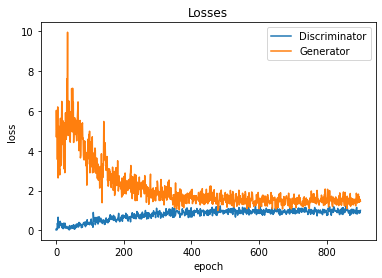

In [42]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

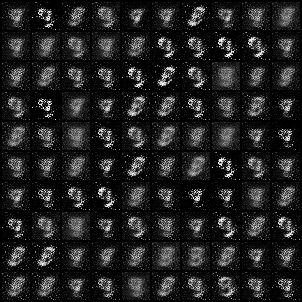

In [39]:
Image('./samples/fake_images-0010.png')

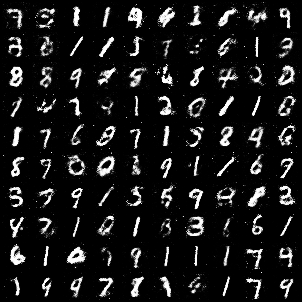

In [40]:
Image('./samples/fake_images-0100.png')

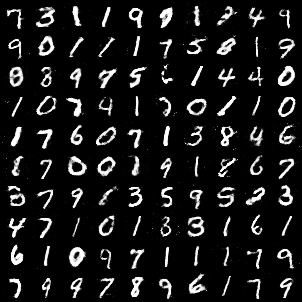

In [41]:
Image('./samples/fake_images-0300.png')